['./input/chessboard.png']


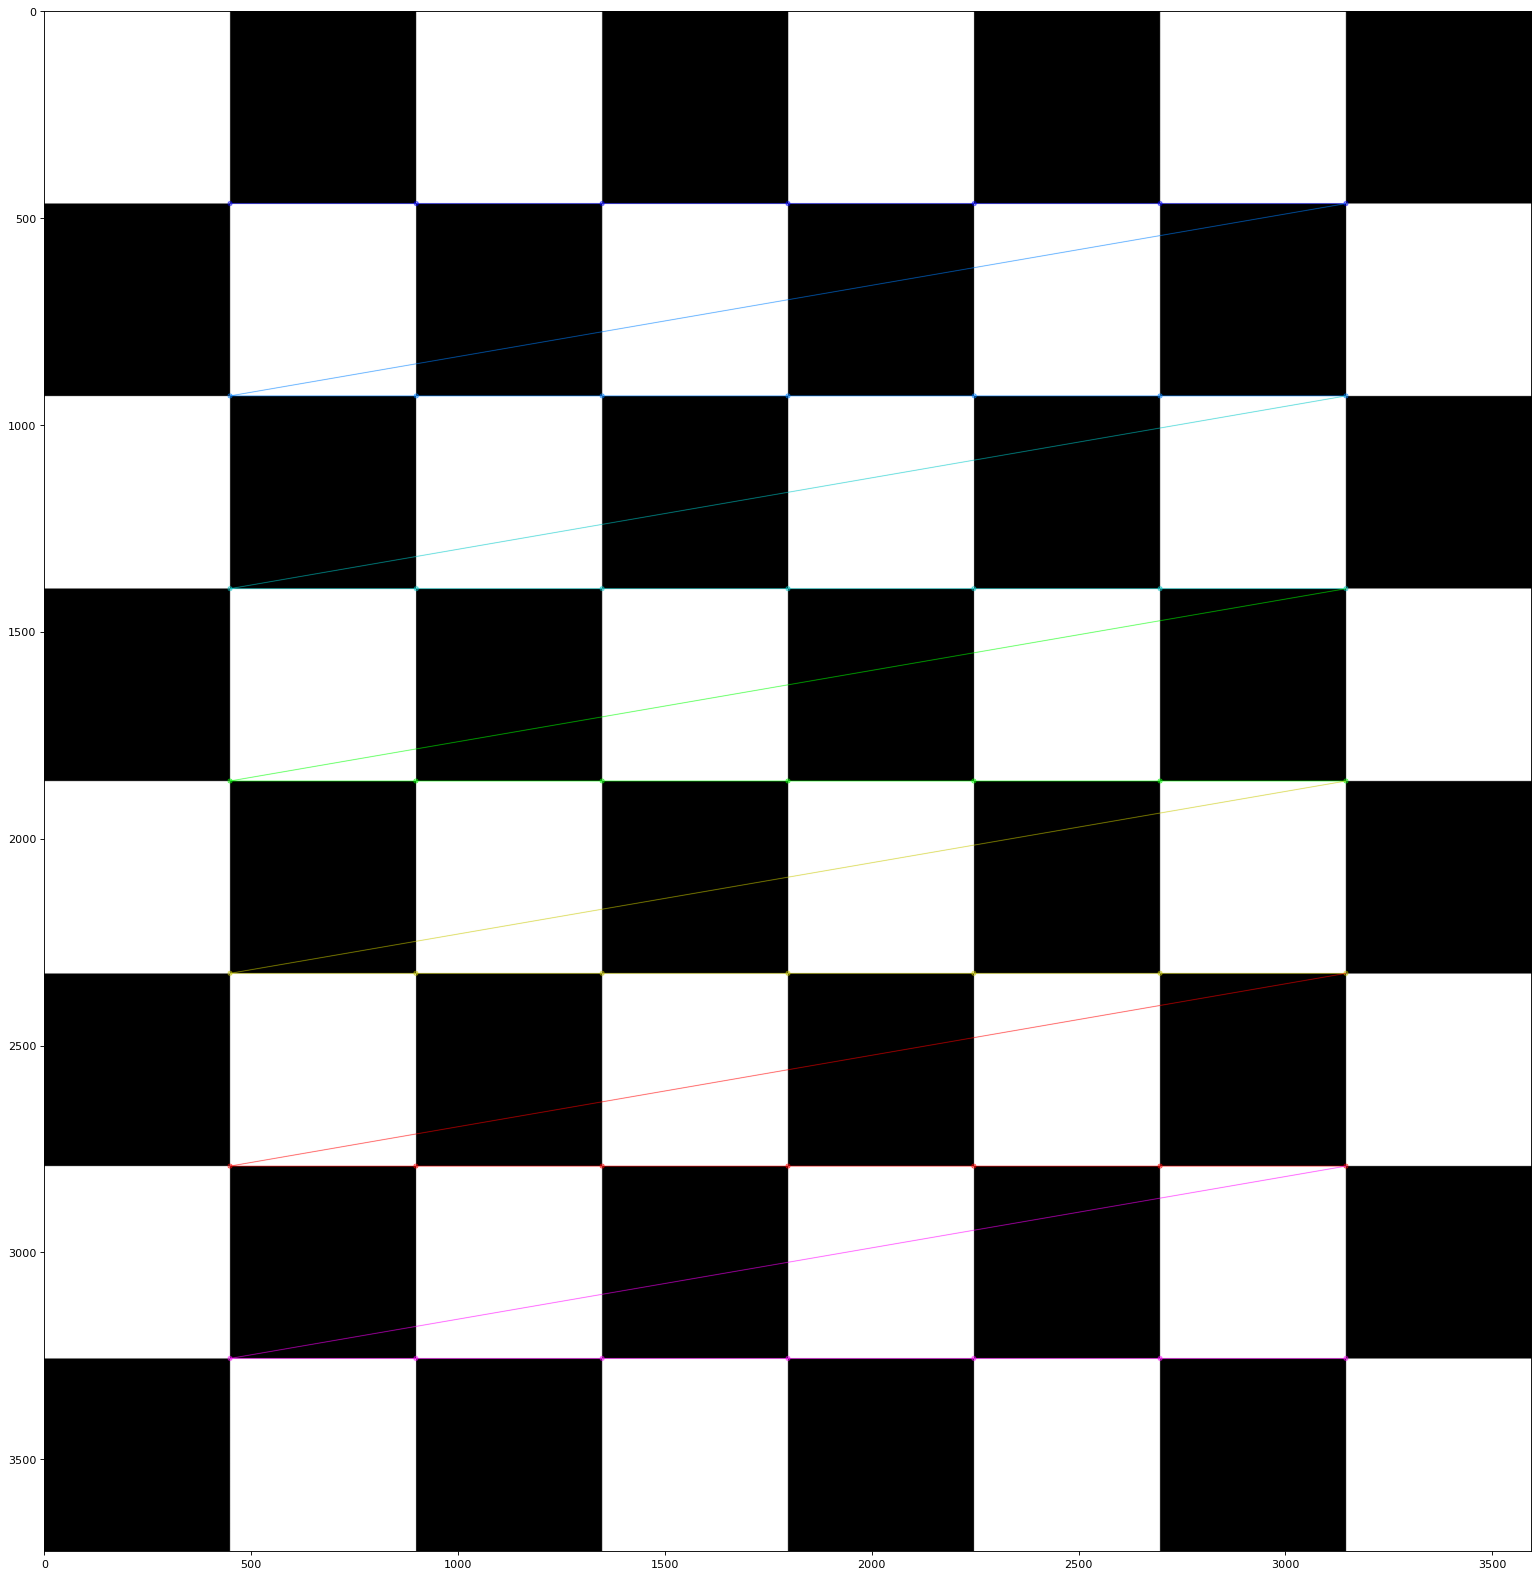

In [43]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
# images = glob.glob('./input/board*.JPG')
images = glob.glob('./input/chessboard.png') #WORKING
# images = glob.glob('./input/testboard.JPG')
print(images)
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,7), None)
    # print(ret, corners)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,7), corners2, ret)
        figure(figsize=(25,25), dpi=80)
        plt.imshow(img)
        plt.show()
        # cv.imshow('img', img)
        # cv.waitKey(500)
cv.destroyAllWindows()

In [71]:
LENGTH = 7
WIDTH = 7
ZEROES_SIZE = (LENGTH * WIDTH, 3)

['./input/onlinetest.png']


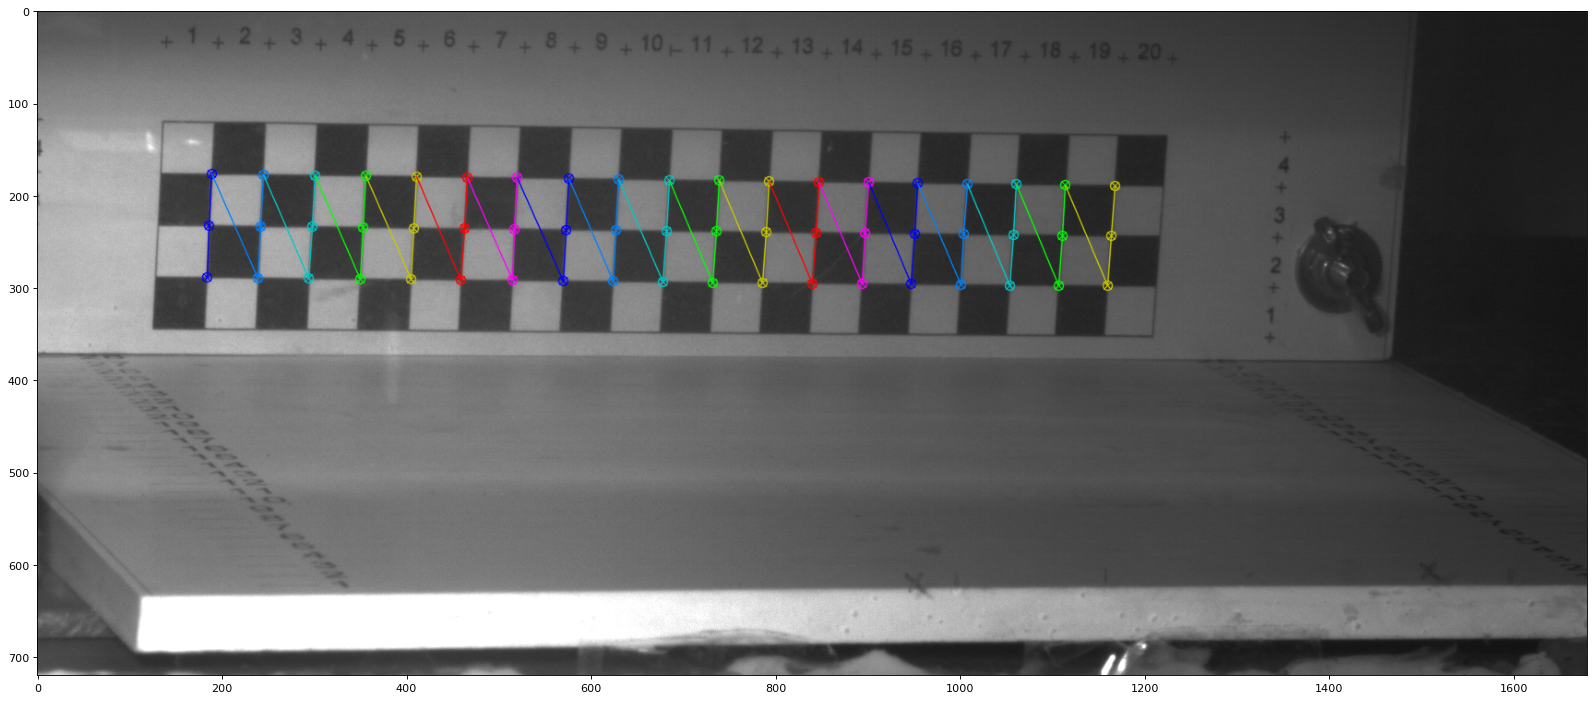

In [57]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros(ZEROES_SIZE, np.float32)
objp[:,:2] = np.mgrid[0:LENGTH,0:WIDTH].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
# images = glob.glob('./input/board*.JPG')
# images = glob.glob('./input/chessboard.png') #WORKING
images = glob.glob('./input/onlinetest.png')
# images = glob.glob('./input/onlinetestpp.jpg')
print(images)
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (LENGTH, WIDTH), None)
    # print(ret, corners)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (LENGTH, WIDTH), corners2, ret)
        figure(figsize=(25,25), dpi=80)
        plt.imshow(img)
        plt.show()
        # cv.imshow('img', img)
        # cv.waitKey(500)
cv.destroyAllWindows()

In [72]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros(ZEROES_SIZE, np.float32)
objp[:,:2] = np.mgrid[0:LENGTH,0:WIDTH].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./input/blackwhitetest.png')
# images = glob.glob('./input/chessboard.png') #WORKING
# images = glob.glob('./input/onlinetest.png')
# images = glob.glob('./input/onlinetestpp.jpg')
print(images)
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (LENGTH, WIDTH), None)
    # print(ret, corners)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (LENGTH, WIDTH), corners2, ret)
        figure(figsize=(25,25), dpi=80)
        plt.imshow(img)
        plt.show()
        # cv.imshow('img', img)
        # cv.waitKey(500)
cv.destroyAllWindows()

['./input/blackwhitetest.png']


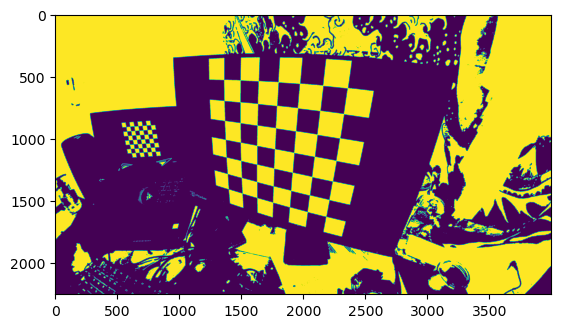

In [70]:
# Load the input image 
image = cv.imread('./input/board2.JPG') 

# Use the cvtColor() function to grayscale the image 
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 
  
(thresh, im_bw) = cv.threshold(gray_image, 128, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
cv.imwrite('blackwhitetest.png', im_bw)

# cv.imshow('Grayscale', im_bw) 
# cv.waitKey(0)   
plt.imshow(im_bw)
plt.show()
  
# Window shown waits for any key pressing event 
cv.destroyAllWindows()